In [99]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 16, 8

In [100]:
buildings = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/building_metadata.csv.gz")
weather = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/weather_train.csv.gz")
energy = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/train.0.csv.gz")

In [101]:
def reduce_mem_usage (df):
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if str(col_type)[:5] == "float":
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.finfo("f2").min and c_max < np.finfo("f2").max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo("f4").min and c_max < np.finfo("f4").max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
        elif str(col_type)[:3] == "int":
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo("i1").min and c_max < np.iinfo("i1").max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo("i2").min and c_max < np.iinfo("i2").max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo("i4").min and c_max < np.iinfo("i4").max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo("i8").min and c_max < np.iinfo("i8").max:
                df[col] = df[col].astype(np.int64)
        elif col == "timestamp":
            df[col] = pd.to_datetime(df[col])
        elif str(col_type)[:8] != "datetime":
            df[col] = df[col].astype("category")
    end_mem = df.memory_usage().sum() / 1024**2
    print('Data usage is less about', round(start_mem - end_mem, 2), 'Мб (минус', round(100 * (start_mem - end_mem) / start_mem, 1), '%)')
    return df

def round_fillna (df, columns):
    for col in columns:
        type_ = "int8"
        if col in ["wind_direction", "year_built", "precip_depth_1_hr"]:
            type_ = "int16"
        if col == "precip_depth_1_hr":
            df[col] = df[col].apply(lambda x:0 if x<0 else x)
        df[col] = np.round(df[col].fillna(value=0)).astype(type_)
    return df

In [102]:
buildings = reduce_mem_usage(buildings)
weather = reduce_mem_usage(weather)
energy = reduce_mem_usage(energy)

Data usage is less about 0.05 Мб (минус 73.9 %)
Data usage is less about 6.53 Мб (минус 68.1 %)
Data usage is less about 195.54 Мб (минус 53.1 %)


In [103]:
energy = pd.merge(left=energy, right=buildings, how="left",
                   left_on="building_id", right_on="building_id")
energy = energy.set_index(["timestamp", "site_id"])
weather = weather.set_index(["timestamp", "site_id"])
energy = pd.merge(left=energy, right=weather, how="left",
                  left_index=True, right_index=True)
energy.reset_index(inplace=True)
energy = energy.drop(columns=["meter"], axis=1)
energy = round_fillna(energy, ["wind_direction", "wind_speed",
        "cloud_coverage", "precip_depth_1_hr",
        "year_built", "floor_count"])
energy = energy[energy["meter_reading"] > 0]
del buildings
del weather

In [104]:
# Error on practice
# data_corr_meta = pd.DataFrame(energy.groupby("building_id").median(),
#         columns=["meter_reading", "square_feet", "year_built", "site_id"])
# data_corr_meta.dropna(inplace=True)
# sns.pairplot(data_corr_meta, height=6)
# plt.show()
# del data_corr_meta

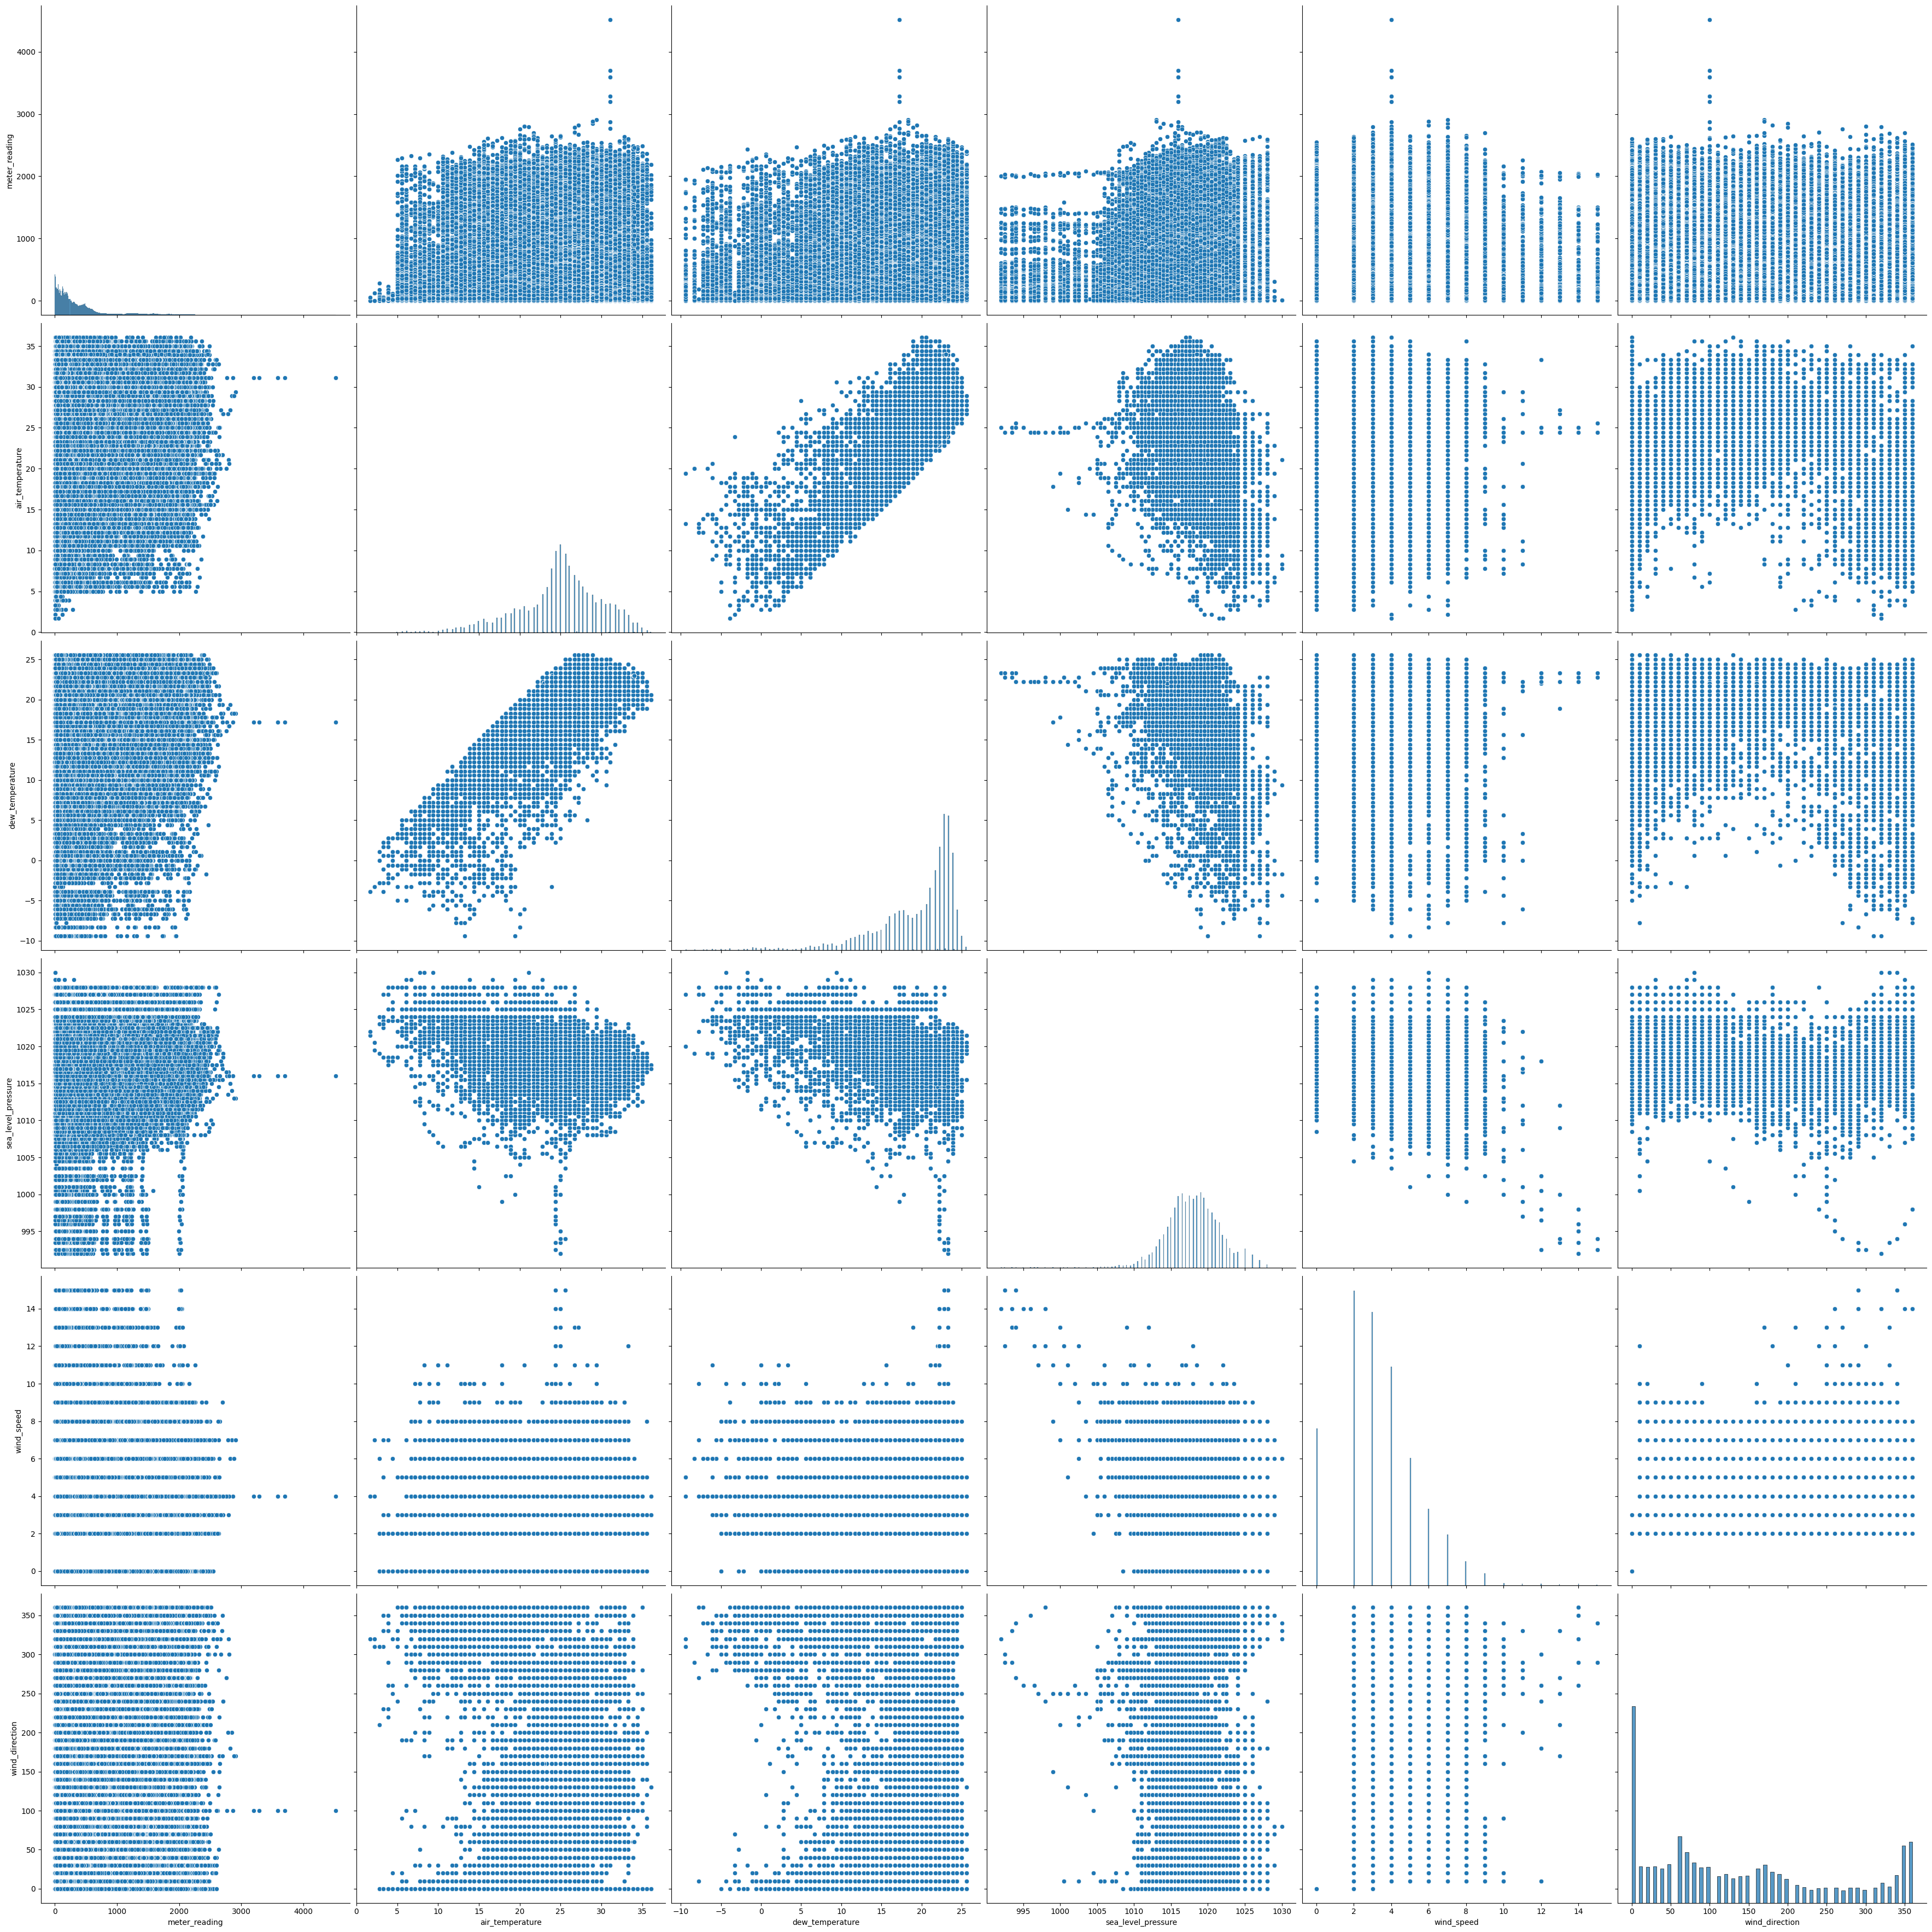

In [105]:
data_corr_weather = pd.DataFrame(energy[energy["site_id"] == 0],
        columns=["meter_reading", "air_temperature", "dew_temperature", 
                 "sea_level_pressure", "wind_speed", "wind_direction"])
data_corr_weather.dropna(inplace=True)
sns.pairplot(data_corr_weather, height=6)
plt.show()
del data_corr_weather

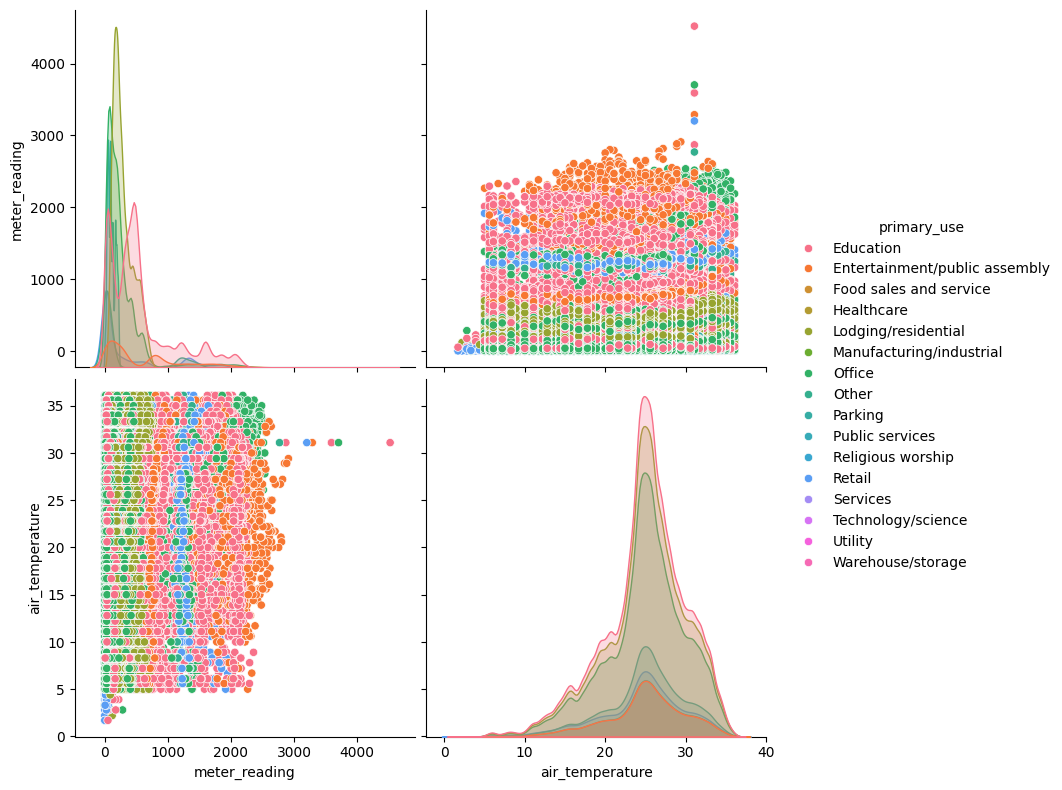

In [106]:
data_corr_temp_primary = pd.DataFrame(energy[energy["site_id"] == 0],
        columns=["meter_reading", "air_temperature", "primary_use"])
data_corr_temp_primary.dropna(inplace=True)
sns.pairplot(data_corr_temp_primary, hue="primary_use", height=4)
plt.show()
del data_corr_temp_primary

In [108]:
# # Error on practice
# energy["hour"] = energy["timestamp"].dt.hour.astype("int8")
# fig = plt.figure(figsize=(12,20))
# for i in range(0,24):
#     fig.add_subplot(8, 3, i+1)
#     df_i = energy[(energy["building_id"] == i) & (energy["meter_reading"]) > 0]
#     df_i_hourly = df_i.groupby("hour").mean().reset_index()
#     x = np.arange(0, 24)
#     y = interp1d(x, df_i_hourly["meter_reading"], kind="cubic")
#     xn = np.arange(0, 23.1, 0.1)
#     yn = y(xn)
#     plt.plot(np.arange(0, 24), df_i_hourly["meter_reading"], "o",
#             xn, yn, "-")
# plt.show()

In [109]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
dates_range = pd.date_range(start='2015-12-31', end='2017-01-01')
us_holidays = calendar().holidays(start=dates_range.min(),
                                  end=dates_range.max())

In [110]:
energy["dayofweek"] = energy["timestamp"].dt.dayofweek.astype("int8")
energy["day"] = energy["timestamp"].dt.day.astype("int8")
energy["dayofyear"] = energy["timestamp"].dt.dayofyear.astype("int16")
energy["month"] = energy["timestamp"].dt.month.astype("int8")
# energy["week"] = energy["timestamp"].dt.week.astype("int8")
energy["date"] = pd.to_datetime(energy["timestamp"].dt.date)
energy["is_holiday"] = (energy['date'].isin(us_holidays)).astype("int8")

# Error on practice
# for col in ["dayofweek", "day", "dayofyear", "month", "date", "is_holiday"]:
#     energy.groupby(col).median()["meter_reading"].plot()
#     plt.show()

In [111]:
del energy